# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from bandit_library import *
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

/home/eric/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Defining Inputs

In [3]:
##INTERVAL AND TRADING PERIOD##

interval = '1d'
tau = 150
m = 330

trade_start_time = datetime.datetime(2019,10,11,17,30)

if interval == '1d':
    hist_start_time = trade_start_time - datetime.timedelta(days=tau)
    trade_end_time = trade_start_time + datetime.timedelta(days=m)
if interval == '1wk':
    hist_start_time = trade_start_time - datetime.timedelta(days=7*tau)
    trade_end_time = trade_start_time + datetime.timedelta(days=7*m)
    
hist_end_time = trade_end_time

# TICKERS
# tickers = ['AC.PA','ALO.PA','AI.PA','ATO.PA','CAP.PA','ORA.PA','RI.PA','TTE.PA',
#            'PINR.PA','SW.PA','SU.PA','BN.PA','PAASI.PA','PAEEM.PA','ML.PA','SK.PA']
#tickers = ['AI.PA','ALO.PA','SU.PA','SK.PA','ORA.PA']
tickers = ['AAPL','MSFT','GOOGL','AMZN','AI.PA','ORA.PA','TTE.PA','SW.PA','AC.PA']
n_assets = len(tickers)

In [4]:
data = Data(tickers)
hist_returns = data.get_data(hist_start_time,hist_end_time,interval)

Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
[*********************100%%**********************]  9 of 9 completed


# Brief Co-Dependence Analysis

In [5]:
# sns.heatmap(hist_returns.cov())
# plt.title('Covariance Matrix')

Text(0.5, 1.0, 'Spearman Correlation')

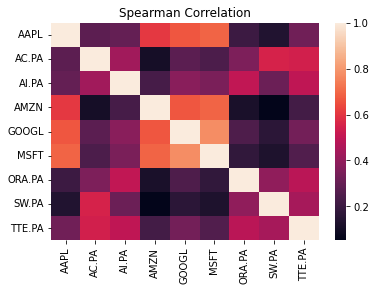

In [6]:
sns.heatmap(hist_returns.corr(method='spearman'))
plt.title('Spearman Correlation')

Let us compute the covariance matrix of our returns :

In [7]:
cov_matrix = get_cov(hist_returns)

This matrix is $\Sigma_k$ but we will need to eigen-decompose it .

We now estimate the average return $\mathbb{E}[\textbf{R}_k] \in \mathbb{R}_n $

 - $\tau$ represents the size of the training data 
 - Example : if we study an interval of 300 days, $\tau$ = 300
 - Our 'training' returns are in the interval $[k-\tau, k-1]$, hence the length is $k-1 - (k-\tau) + 1 = \tau$

NB : 
- hist_start_time = trading_start_time - $\tau$
- To ensure that the average return and the covariance matrix of assets returns $\Sigma_k$ are estimated by $(\textbf{R}_{k-\tau},..,\textbf{R}_{k-1})$

In [8]:
k=1

In [9]:
E_R,Sigma = calculate_return_and_cov(hist_returns,k,tau,interval,trade_start_time)

The next step is to decompose of the covariance matrix :

In [10]:
Lambda, H = eigen_decomposition(Sigma)
Lambdas = np.diag(Lambda)

- Lambda corresponds to $\Lambda_k$
- Lambdas is a numpy array containing all the eigenvalues (the diagonal of $\Lambda_k$)
- H corresponds to $\mathcal{H}_k$

Now we compute the renormalized similarity matrices and eigenvalues :

In [11]:
Lambda_norm, H_norm = normalization(n_assets,Lambda,H)
Lambdas_norm = np.diag(Lambda_norm)

In [12]:
Sigma_tilde, Lambda_tilde = np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm)),np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm))

- Lambda_tilde and Sigma_tilde corresponds to $\tilde{\Lambda_k}$
- H_norm corresponds to $\tilde{\mathcal{H}_k}$

We have a constructed a set of n uncorrelated portfolios with return $\textbf{H}_k^{T} \textbf{R}_k$

In [13]:
portfolio_returns = np.matmul(np.transpose(H),np.array(E_R))

At time $t_k$ the return of the i-th orthogonal portfolio is estimated as $\tilde{H_{k,i}}R_{k,i}$
              and the variance with $\tilde{\lambda_{k,i}}$                  

In [14]:
SR = get_sharpe_ratios(H,Lambdas,E_R)
SR

array([ 33.12033603,  67.62308274,  87.31984498, 102.40868975,
       105.69039885, 107.56174305, 123.94018339, 152.03955022,
       195.71619484])

# All in One - Algorithm Orthogonal Bandit Portfolio

In [15]:
#interval = '1d'
tau = 300
m = 250
# l = 2 #n_assets / 2 looks good for small n_assets

In [16]:
# do the same as in the cell below but add a for loop for possible different values of l and save the l that yields the best Sharpe Ratio
for l_t in range(1,n_assets):
    SR_l = []
    returns,returnsEW,CW_OBP,CW_EW,weights,choices_inf,choices_sup = run_obp(
    interval=interval,tau=tau,l=l_t,m=m,
    hist_start_time=hist_start_time,hist_end_time=hist_end_time,trade_start_time=trade_start_time,tickers=tickers)
    mean_returns_obp = np.mean(returns)
    std_obp = np.std(returns)
    SR_obp = mean_returns_obp/std_obp
    SR_l.append(SR_obp)
    print('\n')
    print(f"l = {l_t} : SR = {SR_obp}")
    print('\n')
optimal_l = np.argmax(SR_l) + 1
print('Best l found :',optimal_l)

Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
[***********           22%%                      ]  2 of 9 completed

[*********************100%%**********************]  9 of 9 completed


l = 1 : SR = 1.2289613070404992


Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
[*********************100%%**********************]  9 of 9 completed


l = 2 : SR = 0.47352026172873196


Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
[*********************100%%**********************]  9 of 9 completed


l = 3 : SR = 0.17722653478522182


Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
[*********************100%%**********************]  9 of 9 completed


l = 4 : SR = -0.14539680005285718


Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
[*********************100%%**********************]  9 of 9 completed


l = 5 : SR = 0.4551261716058338


Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
[*********************100%

In [17]:
l = optimal_l

In [18]:
returns,returnsEW,CW_OBP,CW_EW,weights,choices_inf,choices_sup = run_obp(
    interval=interval,tau=tau,l=l,m=m,
    hist_start_time=hist_start_time,hist_end_time=hist_end_time,trade_start_time=trade_start_time,tickers=tickers)
returns_JS,returnsEW_JS,CW_OBP_JS,CW_EW_JS,weights_JS,choices_inf_JS,choices_sup_JS = run_obp_JS(
    interval=interval,tau=tau,l=l,m=m,
    hist_start_time=hist_start_time,hist_end_time=hist_end_time,trade_start_time=trade_start_time,tickers=tickers)

Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
[*********************100%%**********************]  9 of 9 completed
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
[*********************100%%**********************]  9 of 9 completed


In [19]:
#James_Stein(df['Close']).shape
# np.sum(df['Close'])*2

In [20]:
mean_return = np.mean(np.array(returns)) # +1 if gross, nothing if net return
mean_return_ew = np.mean(np.array(returnsEW))
std_obp = np.std(returns)
std_ew = np.std(returnsEW)
obp_SR = mean_return/std_obp
ew_SR = mean_return_ew/std_ew
#std = np.sqrt((1/(m-1))*np.sum((returns-mean_return)**2))
#std_ew = np.sqrt((1/(m-1))*np.sum((returnsEW-mean_return_ew)**2))

print('PORTFOLIO INFORMATIONS')
print('------------')
print('OBP - Sharpe Ratio :',obp_SR)
print('EW - Sharpe Ratio :',ew_SR)
print('------------')
print('Cumulative Wealth OBP',CW_OBP)
print('Cumulative Wealth EW',CW_EW)
print('Cumulative Wealth OBP JS',CW_OBP_JS)
print('Cumulative Wealth EW JS',CW_EW_JS)
print('------------')
print('Choices Inf',choices_inf)
print('Choices Sup',choices_sup)

PORTFOLIO INFORMATIONS
------------
OBP - Sharpe Ratio : 1.2289613070404992
EW - Sharpe Ratio : 1.0518883054141392
------------
Cumulative Wealth OBP [1.0007751994013667, 1.0015509997368452, 1.0023274014722794, 1.0029839048811655, 1.003568642365137, 1.0041672697320274, 1.0049086410017574, 1.0055743842961629, 1.0062405686397504, 1.0069071943247112, 1.0077856476671352, 1.00867715870454, 1.0096138766396572, 1.0105660810255388, 1.011482511365025, 1.012399772767994, 1.0133178659880948, 1.0142963543157764, 1.01506870371067, 1.0158354102354261, 1.0166907689153408, 1.0176115564713937, 1.018533177958224, 1.019455634131099, 1.0205407843796541, 1.0216900696347258, 1.0228038778576953, 1.0239876665653411, 1.0251406475431057, 1.0262949267446464, 1.027450505631726, 1.0283850352037198, 1.0293307409340329, 1.0301621342677898, 1.030992579951413, 1.0321356643744173, 1.033280016160566, 1.0344256367150129, 1.0354227307151744, 1.0364045671264661, 1.0373446435159068, 1.0382598608478464, 1.0391719277967897, 1

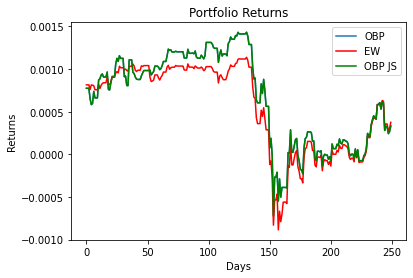

In [21]:
plt.plot(returns[:],label='OBP')
plt.plot(returnsEW[:],'r',label='EW') # : to specifiy indexes you want to plot easily
plt.plot(returns_JS[:],'g',label='OBP JS')
plt.title('Portfolio Returns')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.show()

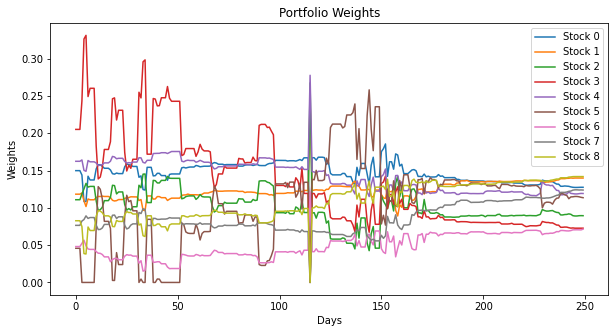

In [22]:
weights_per_stock = np.zeros((n_assets,m))
for i in range(n_assets):
    weights_per_stock[i] = [weights[j][i] for j in range(len(weights))]

plt.figure(figsize=(10,5))       
for i in range(n_assets):
    plt.plot(weights_per_stock[i],label='Stock '+str(i))
plt.title('Portfolio Weights')
plt.xlabel('Days')
plt.ylabel('Weights')
plt.legend()
plt.show()

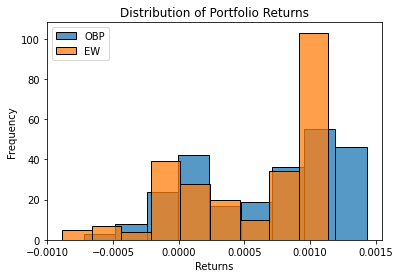

In [23]:
sns.histplot(returns,label='OBP')
sns.histplot(returnsEW,label='EW')
plt.title('Distribution of Portfolio Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Comparing OBP and EW Portfolios CW')

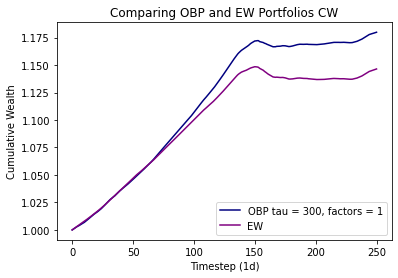

In [24]:
plt.plot(np.arange(0,m+1,1),([1]+CW_OBP),color='navy',label=f'OBP tau = {tau}, factors = {l}')
plt.plot(np.arange(0,m+1,1),[1]+CW_EW,color='purple',label='EW')
plt.ylabel('Cumulative Wealth')
plt.xlabel(f'Timestep ({interval})')
plt.legend()
plt.title('Comparing OBP and EW Portfolios CW')

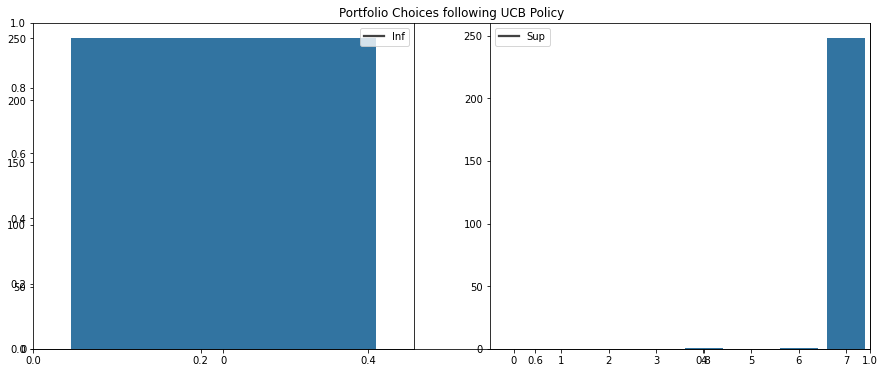

In [25]:
# do a bar plot of the choices inf and sup
plt.figure(figsize=(15,6))
plt.title('Portfolio Choices following UCB Policy')

plt.subplot(1,2,1)
sns.barplot(x=[i for i in range(len(choices_inf))],y=choices_inf)
plt.xticks(np.arange(0, len(choices_inf)))

plt.legend(['Inf'])

plt.subplot(1,2,2)
sns.barplot(x=[i for i in range(len(choices_sup))],y=choices_sup)
plt.legend(['Sup'])
# only integers on the x axis
plt.xticks(np.arange(0, n_assets-l, step=1))

plt.show()

Text(0.5, 1.0, 'AAPL Returns')

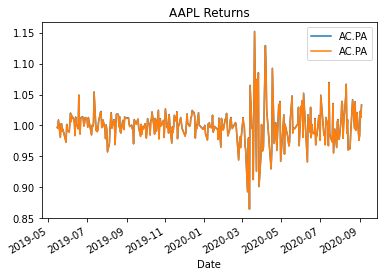

In [26]:
hist_returns['AC.PA'].plot()
James_Stein(hist_returns)['AC.PA'].plot(ax=plt.gca())
plt.legend()
plt.title('AAPL Returns')

Text(0.5, 1.0, 'Difference between Vanilla and James Stein returns over time')

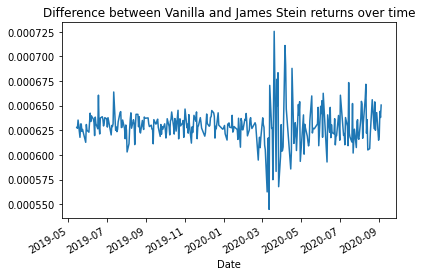

In [27]:
(hist_returns['AC.PA']-James_Stein(hist_returns)['AC.PA']).plot()
plt.title('Difference between Vanilla and James Stein returns over time')

In [28]:
obp_test2 = OBP(interval,l,m,-220+tau,hist_start_time,hist_end_time,trade_start_time,tickers)
obp_test1 = OBP(interval,l,m,tau,hist_start_time,hist_end_time,trade_start_time,tickers)

In [29]:
obp_test1.run_obp()
obp_test2.run_obp()

Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
[*********************100%%**********************]  9 of 9 completed
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
[*********************100%%**********************]  9 of 9 completed


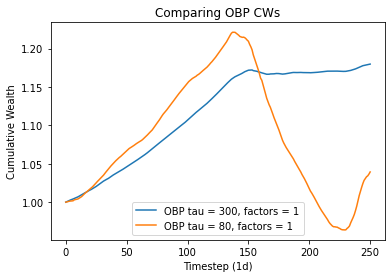

In [30]:
# compare the two CWs
plt.plot(np.arange(0,m+1,1),[1]+obp_test1.CW_OBP,label=f'OBP tau = {obp_test1.tau}, factors = {obp_test1.l}')
plt.plot(np.arange(0,m+1,1),[1]+obp_test2.CW_OBP,label=f'OBP tau = {obp_test2.tau}, factors = {obp_test2.l}')
plt.ylabel('Cumulative Wealth')
plt.xlabel(f'Timestep ({interval})')
plt.legend()
plt.title('Comparing OBP CWs')
plt.show()

In [34]:
heavy_returns = heavy_tailed_returns(start_date=hist_start_time,end_date=hist_end_time,interval=interval)

<Axes: xlabel='Date'>

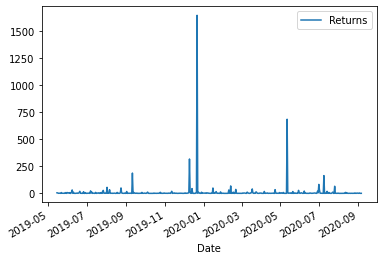

In [35]:
heavy_returns.plot()

array([[<Axes: title={'center': 'Returns'}>]], dtype=object)

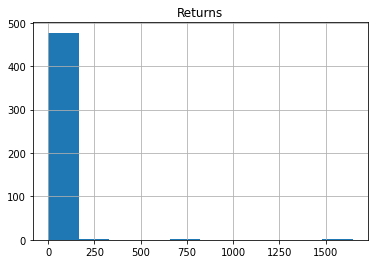

In [36]:
heavy_returns.hist()